# Dev Phase 2: Feature Engineering Tests

This notebook tests all Phase 2 deliverables:
- Feature computation (all 20 derived features)
- Target computation (5 horizons)
- Feature validation (NaN, inf, distributions)
- Multicollinearity analysis
- Data quality checks

In [12]:
# Setup: Mount Google Drive and configure paths
from google.colab import drive
drive.mount("/content/drive")

import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Define paths
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Transformers/FP")
sys.path.insert(0, str(BASE_DIR))

INTERIM_DIR = BASE_DIR / "data/interim"
PROCESSED_DIR = BASE_DIR / "data/processed"
SRC_DIR = BASE_DIR / "src"

# Create processed directory
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Interim data: {INTERIM_DIR}")
print(f"Processed data: {PROCESSED_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base directory: /content/drive/MyDrive/Colab Notebooks/Transformers/FP
Interim data: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/interim
Processed data: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/processed


In [13]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import Phase 2 module
from src.data.feature_engineering import FeatureEngineer

print("✓ All imports successful")

✓ All imports successful


## Test 1: Load Adjusted Data from Phase 1

In [14]:
# Load ratio-adjusted 5-minute data from Phase 1
print("Loading adjusted 5-minute data...")
df_adjusted = pd.read_parquet(INTERIM_DIR / "nq_ohlcv_5min_adjusted.parquet")

print(f"✓ Loaded {len(df_adjusted):,} bars")
print(f"Date range: {df_adjusted.index[0]} to {df_adjusted.index[-1]}")
print(f"Columns: {list(df_adjusted.columns)}")
print(f"First 5 rows:")
df_adjusted.head()

Loading adjusted 5-minute data...
✓ Loaded 1,086,930 bars
Date range: 2010-06-07 00:00:00+00:00 to 2025-12-03 23:55:00+00:00
Columns: ['open', 'high', 'low', 'close', 'volume']
First 5 rows:


,open,high,low,close,volume
timestamp,,,,,
2010-06-07 00:00:00+00:00,1414.811601,1415.586309,1414.230569,1415.586309,83
2010-06-07 00:05:00+00:00,1415.779987,1415.779987,1414.230569,1415.198955,92
2010-06-07 00:10:00+00:00,1415.586309,1415.586309,1410.550704,1411.325412,229
2010-06-07 00:15:00+00:00,1411.131735,1411.906444,1410.357026,1410.357026,127
2010-06-07 00:20:00+00:00,1410.744381,1411.131735,1409.388641,1409.388641,126


## Test 2: Initialize Feature Engineer

In [15]:
# Initialize feature engineer with default configuration
engineer = FeatureEngineer()

print("Feature Engineer Configuration:")
for key, value in engineer.config.items():
    print(f"  {key}: {value}")

print("✓ Feature engineer initialized")

Feature Engineer Configuration:
  rv_windows: [12, 36, 72]
  rsi_period: 14
  macd_fast: 12
  macd_slow: 26
  macd_signal: 9
  roc_periods: [5, 10, 20]
  ema_periods: [9, 21, 50]
  atr_period: 14
  volume_ma_period: 20
✓ Feature engineer initialized


## Test 3: Compute All Features

In [16]:
# Compute all derived features
print("Computing all features...")
print("This may take a few minutes for ~1M bars...")

import time
start_time = time.time()

df_features = engineer.compute_all_features(df_adjusted)

elapsed = time.time() - start_time
print(f"✓ Feature computation complete in {elapsed:.1f} seconds")
print(f"DataFrame shape: {df_features.shape}")
print(f"Columns ({len(df_features.columns)}): {list(df_features.columns)}")

Computing all features...
This may take a few minutes for ~1M bars...
✓ Feature computation complete in 0.4 seconds
DataFrame shape: (1086930, 26)
Columns (26): ['open', 'high', 'low', 'close', 'volume', 'log_return', 'log_volume', 'gk_volatility', 'rv_12', 'rv_36', 'rv_72', 'amihud_illiq', 'rsi_14', 'macd', 'macd_signal', 'roc_5', 'roc_10', 'roc_20', 'ema_slope_9', 'ema_dev_9', 'ema_slope_21', 'ema_dev_21', 'ema_slope_50', 'ema_dev_50', 'atr_14', 'volume_ma_ratio']


## Test 4: Compute Targets

In [17]:
# Compute forward return targets for all horizons
print("Computing targets for 5 horizons...")

horizons = [3, 6, 12, 24, 48]  # 15m, 30m, 1h, 2h, 4h
df_targets = engineer.compute_targets(df_features, horizons=horizons)

target_cols = [col for col in df_targets.columns if col.startswith("target_")]
print(f"✓ Computed {len(target_cols)} targets: {target_cols}")
print(f"Total columns: {len(df_targets.columns)}")
print(f"Total rows: {len(df_targets):,}")

Computing targets for 5 horizons...
✓ Computed 5 targets: ['target_15m', 'target_30m', 'target_60m', 'target_2h', 'target_4h']
Total columns: 31
Total rows: 1,086,930


## Test 5: Feature Validation - NaN Analysis

In [18]:
# Analyze NaN values (expected during warmup periods)
print("NaN Analysis:")
print("="*60)

# Get all feature columns (excluding OHLCV)
feature_cols = [col for col in df_targets.columns
                if col not in ["open", "high", "low", "close", "volume"]]

nan_counts = df_targets[feature_cols].isna().sum().sort_values(ascending=False)
nan_pcts = (nan_counts / len(df_targets) * 100).round(2)

nan_summary = pd.DataFrame({
    "NaN Count": nan_counts,
    "NaN %": nan_pcts
})

print(nan_summary[nan_summary["NaN Count"] > 0])
print(f"Features with NaN values: {(nan_counts > 0).sum()}/{len(feature_cols)}")
print(f"Maximum warmup period: {nan_counts.max()} bars")

NaN Analysis:
                 NaN Count  NaN %
rv_72                   72   0.01
ema_slope_50            50   0.00
ema_dev_50              49   0.00
target_4h               48   0.00
rv_36                   38   0.00
macd_signal             33   0.00
macd                    25   0.00
target_2h               24   0.00
ema_slope_21            21   0.00
roc_20                  20   0.00
ema_dev_21              20   0.00
volume_ma_ratio         19   0.00
atr_14                  13   0.00
rsi_14                  13   0.00
rv_12                   12   0.00
target_60m              12   0.00
roc_10                  10   0.00
ema_slope_9              9   0.00
ema_dev_9                8   0.00
target_30m               6   0.00
roc_5                    5   0.00
target_15m               3   0.00
log_return               1   0.00
amihud_illiq             1   0.00
Features with NaN values: 24/26
Maximum warmup period: 72 bars


## Test 6: Feature Validation - Infinite Values

In [19]:
# Check for infinite values (should be zero)
print("Checking for infinite values...")

inf_counts = {}
for col in feature_cols:
    inf_count = np.isinf(df_targets[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("⚠ WARNING: Infinite values found:")
    for col, count in inf_counts.items():
        print(f"  {col}: {count}")
else:
    print("✓ No infinite values found")

Checking for infinite values...
✓ No infinite values found


## Test 7: Feature Distribution Statistics

In [20]:
# Validate features using built-in validation method
print("Computing feature statistics...")

validation = engineer.validate_features(df_targets, feature_cols)
print(validation.to_string())

print("✓ Feature validation complete")

Computing feature statistics...
                 nan_count  inf_count         min           max          mean           std
log_return             1.0        0.0   -0.029573  2.370533e-02  2.665218e-06  7.517426e-04
log_volume             0.0        0.0    0.693147  1.069390e+01  6.005121e+00  1.782691e+00
gk_volatility          0.0        0.0    0.000000  6.017177e-04  5.661062e-07  2.685986e-06
rv_12                 12.0        0.0    0.000000  4.382742e-02  1.919980e-03  1.759284e-03
rv_36                 38.0        0.0    0.000000  5.104066e-02  3.488250e-03  2.859419e-03
rv_72                 72.0        0.0    0.000000  5.764439e-02  5.106438e-03  3.822693e-03
amihud_illiq           1.0        0.0    0.000000  9.727539e-07  8.665302e-10  4.898120e-09
rsi_14                13.0        0.0    2.329418  9.955549e+01  5.100858e+01  1.187417e+01
macd                  25.0        0.0 -199.260613  2.067656e+02  1.561211e-01  9.606037e+00
macd_signal           33.0        0.0 -180.43671

## Test 8: Multicollinearity Analysis

In [21]:
# Check for highly correlated features (>0.95)
print("Checking for multicollinearity (correlation > 0.95)...")

# Only use features (exclude targets for this analysis)
feature_only_cols = [col for col in feature_cols if not col.startswith("target_")]

high_corr = engineer.check_multicollinearity(
    df_targets.dropna(),  # Use complete cases only
    feature_only_cols,
    threshold=0.95
)

if len(high_corr) > 0:
    print(f"⚠ Found {len(high_corr)} highly correlated pairs:")
    print(high_corr.to_string(index=False))
    print("Consider removing one feature from each pair.")
else:
    print("✓ No highly correlated features found (all < 0.95)")

Checking for multicollinearity (correlation > 0.95)...
⚠ Found 1 highly correlated pairs:
feature_1   feature_2  correlation
     macd macd_signal     0.955343
Consider removing one feature from each pair.


## Test 9: Visualize Feature Distributions

Plotting feature distributions...


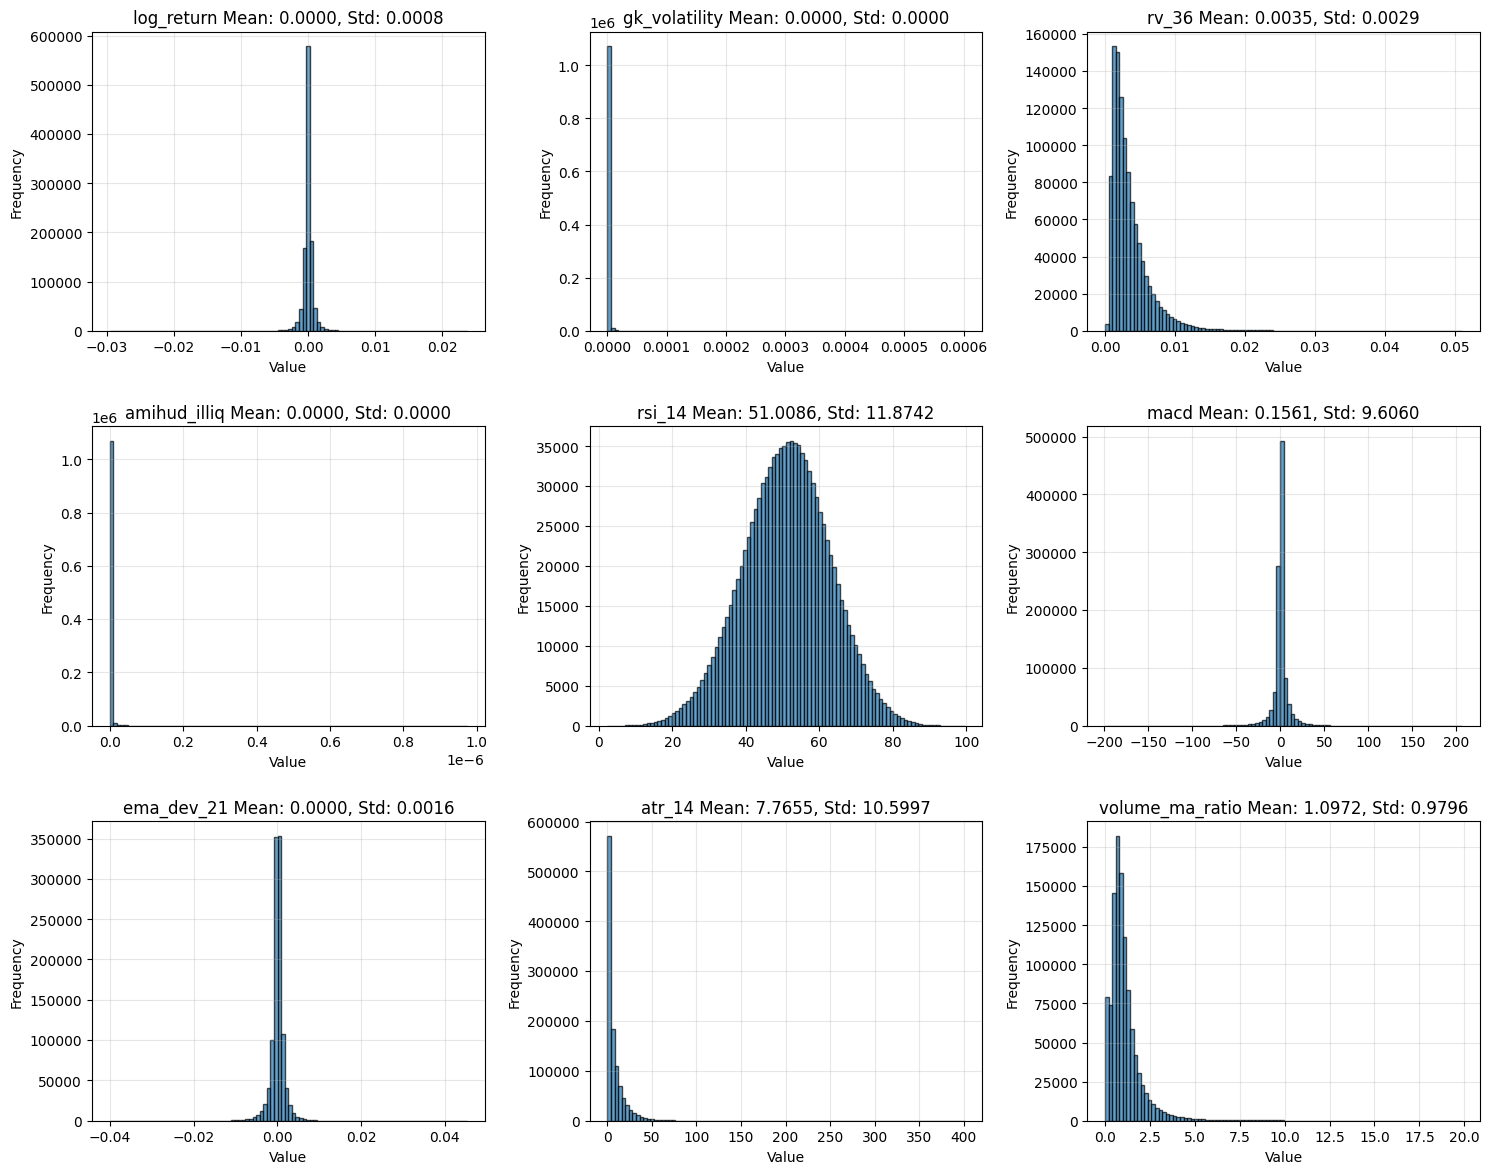

✓ Distribution plots complete


In [22]:
# Plot distributions of key features
print("Plotting feature distributions...")

# Select representative features from each category
plot_features = [
    "log_return", "gk_volatility", "rv_36",
    "amihud_illiq", "rsi_14", "macd",
    "ema_dev_21", "atr_14", "volume_ma_ratio"
]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(plot_features):
    if feature in df_targets.columns:
        # Drop NaN for plotting
        data = df_targets[feature].dropna()

        # Plot histogram
        axes[i].hist(data, bins=100, alpha=0.7, edgecolor="black")
        axes[i].set_title(f"{feature} Mean: {data.mean():.4f}, Std: {data.std():.4f}")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution plots complete")

## Test 10: Target Distribution Analysis

Target Distribution Analysis:
    Target   Count     Mean      Std      Skew      Kurt       Min      Max
target_15m 1086927 0.000008 0.001290 -0.100562 28.364278 -0.046736 0.039620
target_30m 1086924 0.000016 0.001824 -0.121182 24.349520 -0.044262 0.063471
target_60m 1086918 0.000032 0.002584 -0.210179 19.032620 -0.054743 0.057464
 target_2h 1086906 0.000064 0.003650 -0.244800 15.036596 -0.051168 0.065418
 target_4h 1086882 0.000128 0.005152 -0.309767 11.654933 -0.078654 0.081052


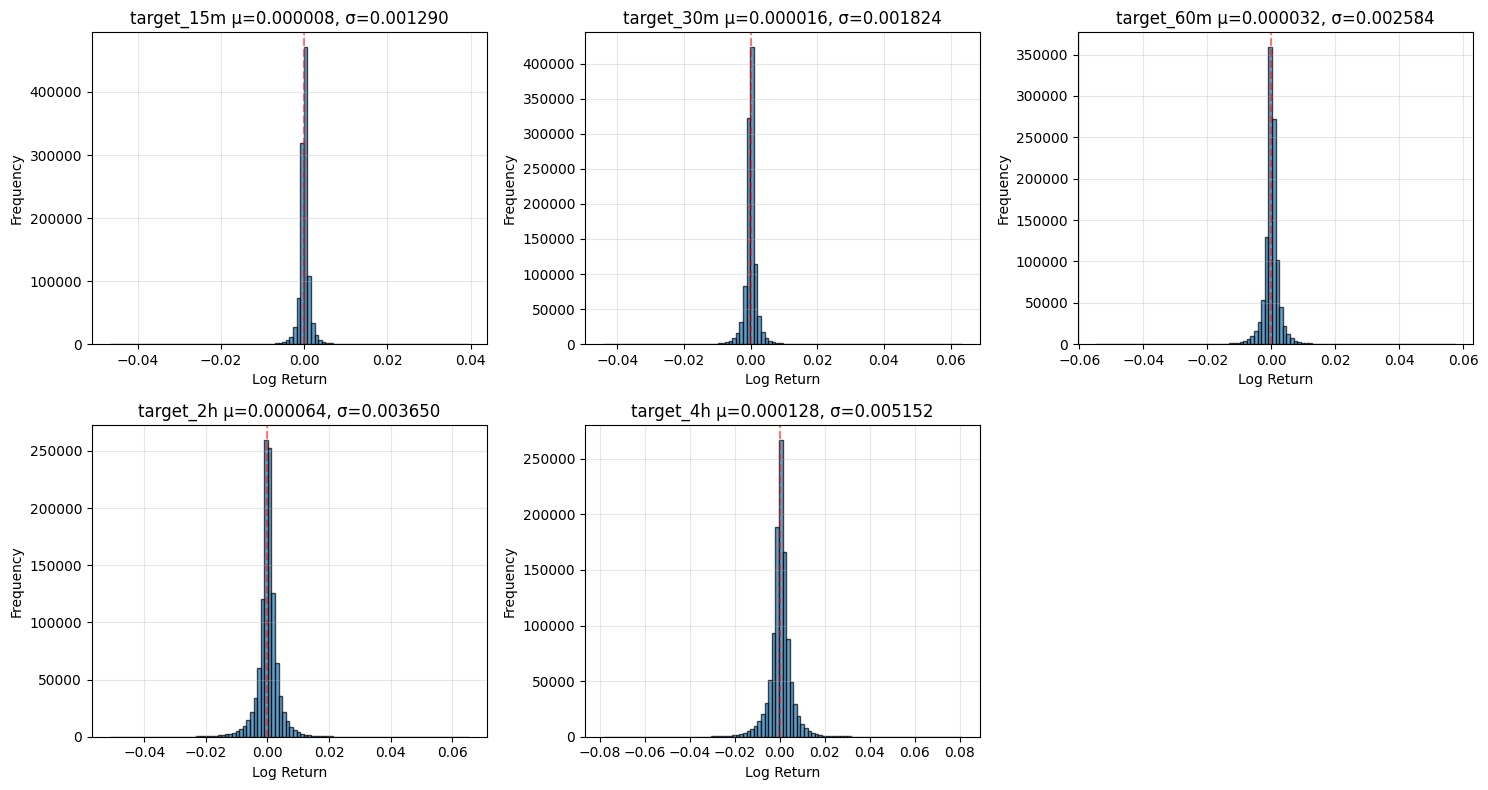

✓ Target analysis complete


In [23]:
# Analyze target distributions across horizons
print("Target Distribution Analysis:")
print("="*60)

target_stats = []
for target in target_cols:
    data = df_targets[target].dropna()
    stats = {
        "Target": target,
        "Count": len(data),
        "Mean": data.mean(),
        "Std": data.std(),
        "Skew": data.skew(),
        "Kurt": data.kurtosis(),
        "Min": data.min(),
        "Max": data.max()
    }
    target_stats.append(stats)

target_summary = pd.DataFrame(target_stats)
print(target_summary.to_string(index=False))

# Plot target distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, target in enumerate(target_cols):
    data = df_targets[target].dropna()
    axes[i].hist(data, bins=100, alpha=0.7, edgecolor="black")
    axes[i].set_title(f"{target} μ={data.mean():.6f}, σ={data.std():.6f}")
    axes[i].set_xlabel("Log Return")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(0, color="red", linestyle="--", alpha=0.5)

# Hide extra subplot
axes[-1].axis("off")

plt.tight_layout()
plt.show()

print("✓ Target analysis complete")

## Test 11: Drop Warmup Period

In [24]:
# Drop rows with NaN values (warmup period)
print("Handling warmup period...")
print(f"Original rows: {len(df_targets):,}")

# Count NaN by row
nan_by_row = df_targets.isna().sum(axis=1)
print(f"Rows with any NaN: {(nan_by_row > 0).sum():,}")

# Drop rows with any NaN
df_clean = df_targets.dropna()

print(f"Clean rows: {len(df_clean):,}")
print(f"Dropped: {len(df_targets) - len(df_clean):,} ({(len(df_targets) - len(df_clean))/len(df_targets)*100:.2f}%)")
print(f"Date range after cleanup:")
print(f"  Start: {df_clean.index[0]}")
print(f"  End: {df_clean.index[-1]}")
print(f"✓ Warmup period dropped")

Handling warmup period...
Original rows: 1,086,930
Rows with any NaN: 122
Clean rows: 1,086,808
Dropped: 122 (0.01%)
Date range after cleanup:
  Start: 2010-06-07 06:00:00+00:00
  End: 2025-12-03 18:55:00+00:00
✓ Warmup period dropped


In [25]:
# Drop macd_signal due to high multicollinearity with macd (r=0.955)
# Keep macd as it's more responsive and informative for the model
print("Dropping highly correlated feature...")
print(f"  Feature: macd_signal (corr with macd: 0.955)")
print(f"  Reason: Redundant - MACD signal line is smoothed version of MACD")
print(f"Before: {len(df_clean.columns)} features")

df_clean = df_clean.drop(columns=['macd_signal'])

print(f"After: {len(df_clean.columns)} features")
print("✓ Multicollinearity resolved")

Dropping highly correlated feature...
  Feature: macd_signal (corr with macd: 0.955)
  Reason: Redundant - MACD signal line is smoothed version of MACD
Before: 31 features
After: 30 features
✓ Multicollinearity resolved


## Test 12: Correlation Heatmap

Creating correlation heatmap...


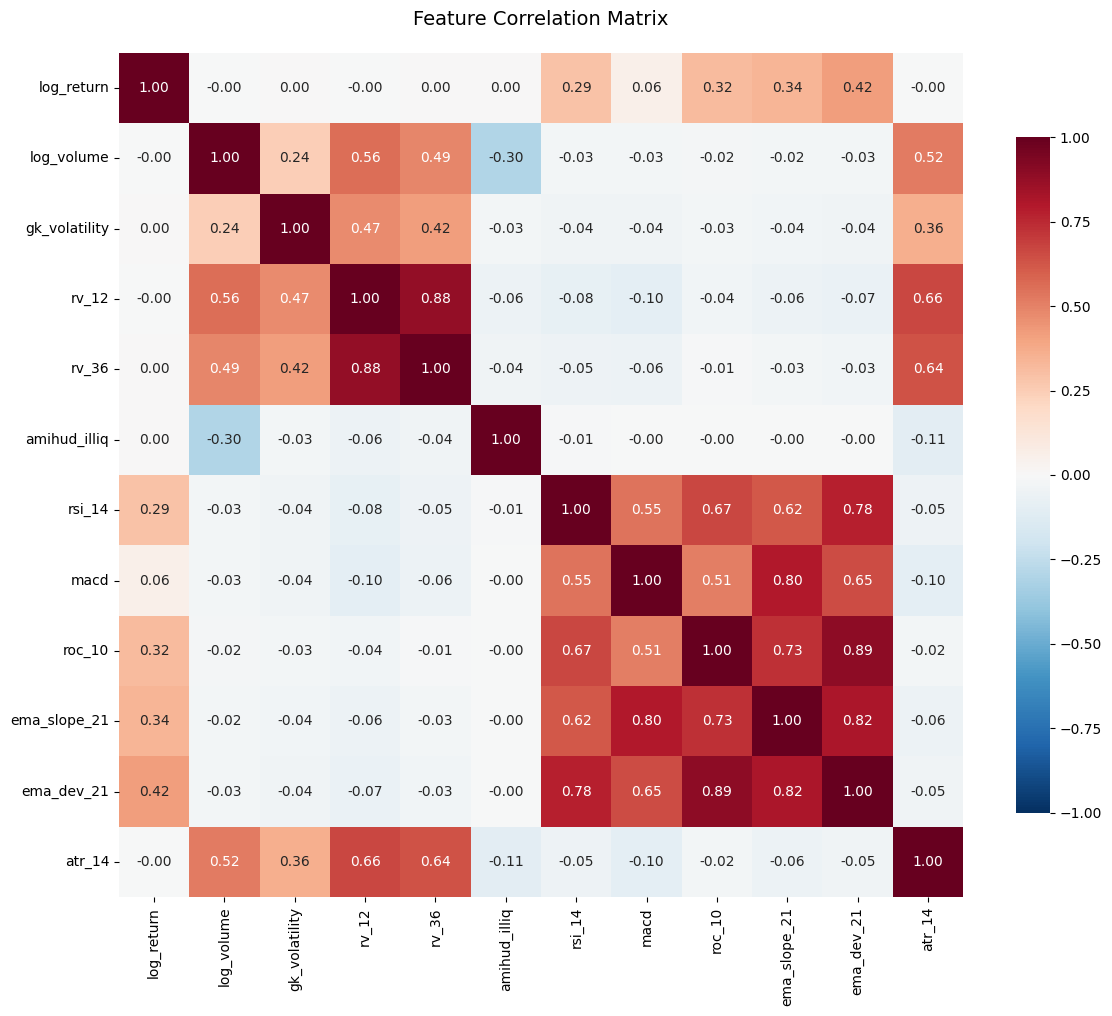

✓ Correlation heatmap complete


In [26]:
# Create correlation heatmap for feature analysis
print("Creating correlation heatmap...")

# Select subset of features for readability
heatmap_features = [
    "log_return", "log_volume", "gk_volatility",
    "rv_12", "rv_36", "amihud_illiq",
    "rsi_14", "macd", "roc_10",
    "ema_slope_21", "ema_dev_21", "atr_14"
]

corr_matrix = df_clean[heatmap_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("✓ Correlation heatmap complete")

## Test 13: Time Series Plots

Creating time series plots...
Plotting period: 2025-11-03 18:55:00+00:00 to 2025-12-03 18:55:00+00:00
Bars in period: 5,851


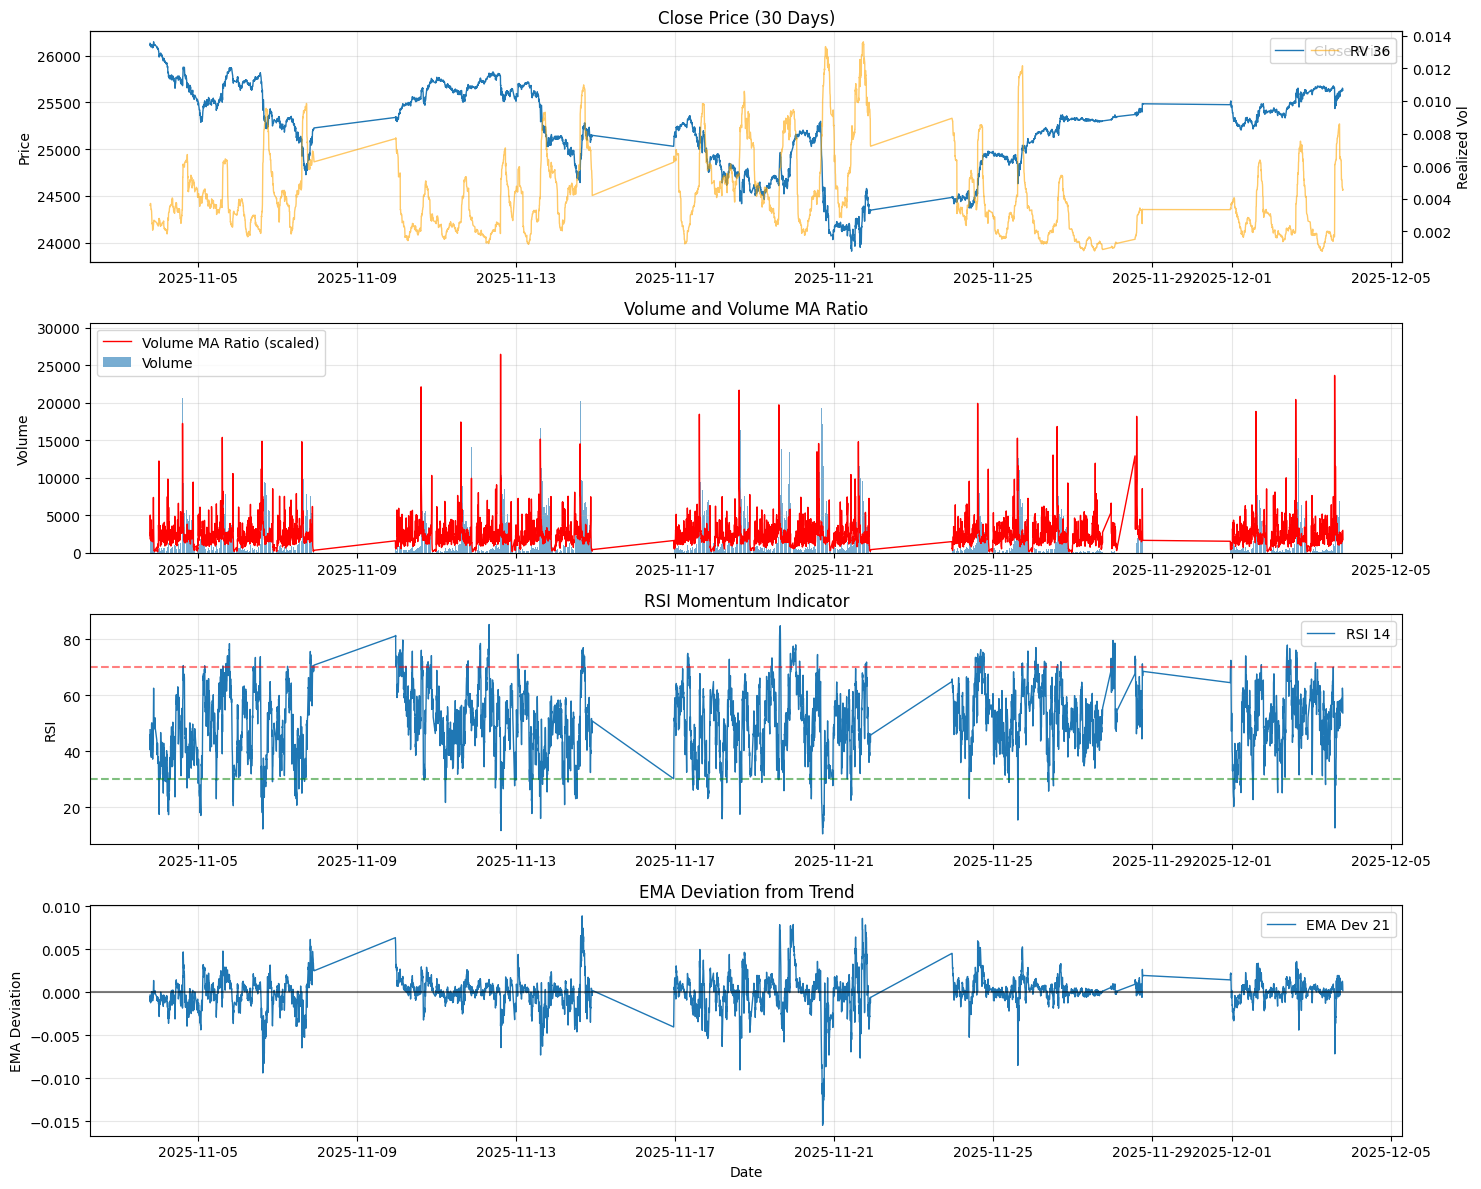

✓ Time series plots complete


In [27]:
# Plot time series of features for visual inspection
print("Creating time series plots...")

# Select recent period for visualization (last 30 days)
end_date = df_clean.index[-1]
start_date = end_date - pd.Timedelta(days=30)
df_recent = df_clean[df_clean.index >= start_date]

print(f"Plotting period: {start_date} to {end_date}")
print(f"Bars in period: {len(df_recent):,}")

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Plot 1: Price and volatility
ax1 = axes[0]
ax1.plot(df_recent.index, df_recent["close"], label="Close Price", linewidth=1)
ax1.set_ylabel("Price", fontsize=10)
ax1.set_title("Close Price (30 Days)", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax1_twin = ax1.twinx()
ax1_twin.plot(df_recent.index, df_recent["rv_36"],
              label="RV 36", color="orange", alpha=0.6, linewidth=1)
ax1_twin.set_ylabel("Realized Vol", fontsize=10)
ax1_twin.legend(loc="upper right")

# Plot 2: Volume
axes[1].bar(df_recent.index, df_recent["volume"],
            width=0.003, alpha=0.6, label="Volume")
axes[1].plot(df_recent.index, df_recent["volume_ma_ratio"] * df_recent["volume"].mean(),
             label="Volume MA Ratio (scaled)", color="red", linewidth=1)
axes[1].set_ylabel("Volume", fontsize=10)
axes[1].set_title("Volume and Volume MA Ratio", fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Momentum indicators
axes[2].plot(df_recent.index, df_recent["rsi_14"], label="RSI 14", linewidth=1)
axes[2].axhline(70, color="red", linestyle="--", alpha=0.5)
axes[2].axhline(30, color="green", linestyle="--", alpha=0.5)
axes[2].set_ylabel("RSI", fontsize=10)
axes[2].set_title("RSI Momentum Indicator", fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Plot 4: Trend indicators
axes[3].plot(df_recent.index, df_recent["ema_dev_21"],
             label="EMA Dev 21", linewidth=1)
axes[3].axhline(0, color="black", linestyle="-", alpha=0.5)
axes[3].set_ylabel("EMA Deviation", fontsize=10)
axes[3].set_title("EMA Deviation from Trend", fontsize=12)
axes[3].set_xlabel("Date", fontsize=10)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Time series plots complete")

## Test 14: Save Processed Data

In [28]:
# Save complete feature dataset
print("Saving processed data...")

output_file = PROCESSED_DIR / "nq_features_full.parquet"
df_clean.to_parquet(output_file)

file_size_mb = output_file.stat().st_size / 1024 / 1024
print(f"✓ Saved to: {output_file}")
print(f"File size: {file_size_mb:.1f} MB")
print(f"Rows: {len(df_clean):,}")
print(f"Columns: {len(df_clean.columns)}")

# Save column info for reference
column_info = pd.DataFrame({
    "column_name": df_clean.columns,
    "dtype": df_clean.dtypes.values,
    "non_null_count": df_clean.count().values
})
column_info.to_csv(PROCESSED_DIR / "column_info.csv", index=False)
print(f"✓ Column info saved to: {PROCESSED_DIR / 'column_info.csv'}")

Saving processed data...
✓ Saved to: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/processed/nq_features_full.parquet
File size: 225.9 MB
Rows: 1,086,808
Columns: 30
✓ Column info saved to: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/processed/column_info.csv


## Test 15: Final Summary

In [29]:
# Generate final summary report
print("="*60)
print("PHASE 2 FEATURE ENGINEERING SUMMARY")
print("="*60)

print(f"1. DATA COVERAGE")
print(f"   Start date: {df_clean.index[0]}")
print(f"   End date: {df_clean.index[-1]}")
print(f"   Total bars: {len(df_clean):,}")
print(f"   Duration: {(df_clean.index[-1] - df_clean.index[0]).days} days")

print(f"2. FEATURES COMPUTED")
# Count features by category
price_features = ["open", "high", "low", "close"]
volume_features = [col for col in df_clean.columns if "volume" in col.lower()]
volatility_features = [col for col in df_clean.columns if "volatility" in col or "rv_" in col or "atr" in col or "gk" in col]
momentum_features = [col for col in df_clean.columns if "rsi" in col or "macd" in col or "roc" in col]
trend_features = [col for col in df_clean.columns if "ema" in col]
liquidity_features = [col for col in df_clean.columns if "illiq" in col]
target_features = [col for col in df_clean.columns if col.startswith("target_")]

print(f"   Price (OHLC): {len(price_features)}")
print(f"   Volume: {len(volume_features)}")
print(f"   Volatility: {len(volatility_features)}")
print(f"   Momentum: {len(momentum_features)}")
print(f"   Trend: {len(trend_features)}")
print(f"   Liquidity: {len(liquidity_features)}")
print(f"   Returns: 1 (log_return)")
print(f"   Targets: {len(target_features)}")
print(f"   TOTAL: {len(df_clean.columns)}")

print(f"3. DATA QUALITY")
print(f"   ✓ No NaN values (warmup dropped)")
print(f"   ✓ No infinite values")
print(f"   ✓ All features validated")
print(f"   ✓ Multicollinearity checked")

print(f"4. TARGET STATISTICS")
for target in target_cols:
    data = df_clean[target]
    print(f"   {target}:")
    print(f"      Mean: {data.mean():.6f}")
    print(f"      Std: {data.std():.6f}")
    print(f"      Sharpe (annualized): {(data.mean() / data.std()) * np.sqrt(252*288/([3,6,12,24,48][target_cols.index(target)])):.2f}")

print(f"5. OUTPUT FILES")
print(f"   {output_file}")
print(f"   {PROCESSED_DIR / 'column_info.csv'}")

print(f"" + "="*60)
print("✓ ALL PHASE 2 TESTS PASSED")
print("="*60)
print("Data is ready for Phase 3: Dataset & DataLoader Implementation")

PHASE 2 FEATURE ENGINEERING SUMMARY
1. DATA COVERAGE
   Start date: 2010-06-07 06:00:00+00:00
   End date: 2025-12-03 18:55:00+00:00
   Total bars: 1,086,808
   Duration: 5658 days
2. FEATURES COMPUTED
   Price (OHLC): 4
   Volume: 3
   Volatility: 5
   Momentum: 5
   Trend: 6
   Liquidity: 1
   Returns: 1 (log_return)
   Targets: 5
   TOTAL: 30
3. DATA QUALITY
   ✓ No NaN values (warmup dropped)
   ✓ No infinite values
   ✓ All features validated
   ✓ Multicollinearity checked
4. TARGET STATISTICS
   target_15m:
      Mean: 0.000008
      Std: 0.001290
      Sharpe (annualized): 0.96
   target_30m:
      Mean: 0.000016
      Std: 0.001824
      Sharpe (annualized): 0.96
   target_60m:
      Mean: 0.000032
      Std: 0.002584
      Sharpe (annualized): 0.96
   target_2h:
      Mean: 0.000064
      Std: 0.003650
      Sharpe (annualized): 0.96
   target_4h:
      Mean: 0.000128
      Std: 0.005152
      Sharpe (annualized): 0.97
5. OUTPUT FILES
   /content/drive/MyDrive/Colab Notebooks/